## Bayesian Optimization of interatomic potential sampling

This is a rework of the methods discussed in the monograph: Packwood, Daniel. Bayesian Optimization for Materials Science. Springer Singapore, 2017.

In [1]:
using StatsBase
using Distributions
using DataFrames
using CSV
using Plots
using Optim
using LinearAlgebra
#using LaTeXStrings
pyplot();

In [2]:
function SquareKernel(r1::Float64,r2::Float64,alpha::Float64,beta::Float64)
    square_dist = (r1-r2)^2;
    K12 = alpha*exp(-1.00e0*beta*square_dist);
    return K12
end

function SquareKernel(r1::Array{Float64},r2::Array{Float64},alpha::Float64,beta::Float64)
    square_dist = (r1-r2)*transpose(r1-r2);
    K = alpha.*exp.(-1.00e0*beta.*square_dist);
    return K
end

function MeanPrior(x::Array{Float64,1})
    n = length(x);
    μ = mean(E_s);
    # nx1 vector filled with mean value of samples
    μ_vec = fill(μ,(n)); 
    return (μ,μ_vec)
end

function CovarianceMatrix(x::Array{Float64,1},alpha::Float64,beta::Float64)
    k = size(x)[1];
    Σ = zeros(k,k); #This is the covariance of the sample points i-k,i-k
    for i=1:k
        for j=1:k
        Σ[i,j] = SquareKernel(x[i],x[j],alpha,beta);
        end
    end
    return Σ
end

function SampleCovariance(s::Float64,x::Array{Float64,1},
    alpha::Float64,beta::Float64)
    k = size(x)[1];
    Σ_i = zeros(1,k); #Row vector
    for i=1:k
        Σ_i[i] = SquareKernel(s,x[i],alpha,beta)
    end
    return Σ_i
end
    
function PosteriorDensity(K_i::Array{Float64,2},K_ii::Array{Float64,2},
        μi::Array{Float64,1},ui::Array{Float64,1})
    K_ii_inv = pinv(K_ii);
    μ = K_i*K_ii_inv*(μi-ui);
    σ = K_i*K_ii_inv*transpose(K_i);
    return (μ,σ)
end

function ExpectedImprovement(s::Array{Float64,1},μs::Array{Float64,1},σs::Array{Float64,1};min=true)
    normal = Normal(0.00e0,1.00e0);
    if min == true
        min_s = minimum(s);
        arg = min_s.-μs;
        normdev = (arg)./sqrt.(σs);
    else
        max_s = maximum(s);
        arg = μs.-max_s;
        normdev = (arg)./sqrt.(σs);
    end
    EI = arg.*cdf.(normal,normdev) + sqrt.(σs).*pdf.(normal,normdev);
    
    bestEIval,bestEIindx = findmax(EI);
    return (bestEIindx,bestEIval,EI)
end

function AddSample!(s::Array{Float64,1},x::Array{Float64,1},indx::Integer)
        append!(x,s[indx]);
end
;

In [3]:
data = CSV.read("Data_Br2_PotentialCurve_Packwood.csv",allowmissing=:none);

Remove any short distance or high energy points. Get random index/samples

In [4]:
filter_slice = data[:,1] .> 1.75;
r_o = data[:r][filter_slice];
E = data[:E][filter_slice];
number_samples = 4;
rand_index = sample(1:length(r_o),number_samples,replace=false);
#rand(1:length(r_o),4)
#randperm(100)[1:10]
ro_s = r_o[rand_index];
E_s = E[rand_index];

Now we need to compute the parameters for the prior distribution. This is $\mu$ and $\sigma$ for a gaussian distribution which is what we assume

In [5]:


#acoeff = 0.50e0;
#L = 0.50e0;
#bcoeff = 1.00e0/(2.00e0*L*L);

#Optimize coefficients
function LogPrior(p::Array{Float64,1},x::Array{Float64,1})
        ns = length(x);
        b = 1.00e0/(2.00e0*p[2]*p[2]);
        Σ = CovarianceMatrix(x,p[1],b)
        #Why is this neccessary
        for k=1:ns-1
            for j=k+1:ns
                Σ[k,j] = SquareKernel(x[k],x[j],p[1],b);
                Σ[j,k] = Σ[k,j]
            end
        end
        Σ_inv = inv(Σ);
    
        mu_x,mu_xvec = MeanPrior(x);
        a = (1.00e0/ns)*transpose(x-mu_xvec)*Σ_inv*(x-mu_xvec);
        det_Σ = 0.50e0*log(abs(det(Σ)));
        logPM = -0.5e0*a - det_Σ;
        return -logPM
end

function ObjFunc(x::Array{Float64};low1=0.005e0,low2=0.005e0)
    lower=[low1,low2];
    upper=[5.00,5.00];
    initial = [0.5e0,0.50e0];
    result= optimize(p->LogPrior(p,x),initial,NelderMead())
    return result #Optim.minimizer(result)
end

minp = ObjFunc(E_s);
acoeff,L=Optim.minimizer(minp)
bcoeff=1.00e0/(2.00e0*L*L);

In [6]:
acoeff=0.50e0;
L = 0.5e0;
bcoeff=1.00e0/(2.00e0*L*L);

Compute the covariance matrix of the sample data. Compute the posterior mean for all the positions r$_i$ and the variance. This is then plotted agains the known values to see how well the Bayesian prediction went.

In [7]:
mu_E,mu_Evec = MeanPrior(E_s);
μ_star = zeros(length(r_o));
σ_star = zeros(length(r_o));

a_indx,a_expimpval = [],[];
nruns = 5;

In [8]:
for j=1:nruns
    Σ = CovarianceMatrix(ro_s,acoeff,bcoeff);
    mu_E,mu_Evec = MeanPrior(E_s);

    for i=1:length(r_o)
        σ_i = SampleCovariance(r_o[i],ro_s,acoeff,bcoeff); 
        μ,σ = PosteriorDensity(σ_i,Σ,mu_Evec,E_s);
        μ_i = mu_E .- μ;
        σ_ii = SquareKernel(r_o[i],r_o[i],acoeff,bcoeff).-σ;
        if σ_ii[1] < 0.00
            σ_ii[1] = -1.00e0*σ_ii[1];
        end
        μ_star[i] = μ_i[1];
        σ_star[i] = σ_ii[1];
    end

    indx,expimpval,EI = ExpectedImprovement(r_o,μ_star,σ_star)
    push!(a_indx,j);
    push!(a_expimpval,EI);
    
    AddSample!(r_o,ro_s,indx);
    AddSample!(E,E_s,indx);
end

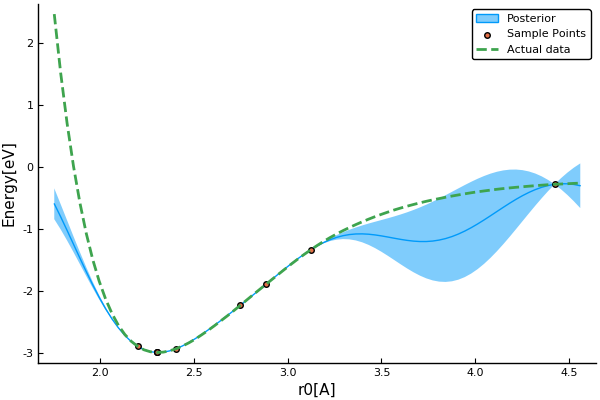

In [9]:
plot(r_o,μ_star,grid=false,ribbon=1.96*sqrt.(σ_star),
fillalpha=.5,xlabel="r0[A]",ylabel="Energy[eV]",label="Posterior")
plot!(ro_s,E_s,seriestype=:scatter,label="Sample Points")
plot!(r_o,E,line=(:dash,2),label="Actual data")

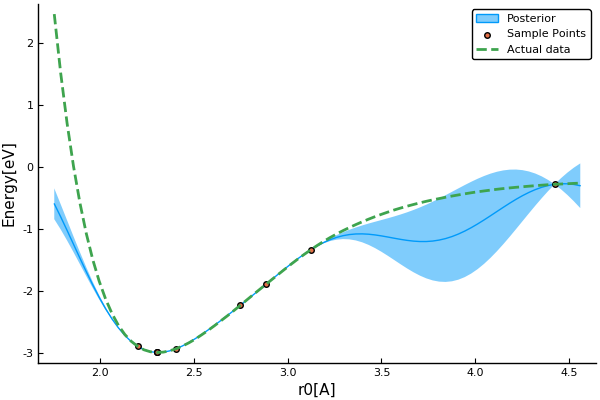

In [10]:
plot(r_o,μ_star,grid=false,ribbon=1.96*sqrt.(σ_star),
fillalpha=.5,xlabel="r0[A]",ylabel="Energy[eV]",label="Posterior")
plot!(ro_s,E_s,seriestype=:scatter,label="Sample Points")
plot!(r_o,E,line=(:dash,2),label="Actual data")

Now use expected improvement to predict the point which minimizes/maximizes the point.